<a href="https://colab.research.google.com/github/indrochoco/NYC-Taxi-prediction/blob/main/Copy_2_of_NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path= '/content/drive/MyDrive/almabetter/Copy of NYC Taxi Data.csv'
taxi_data= pd.read_csv(path)

In [34]:
taxi_data.head(6)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_name,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,dropoff_second,dropoff_day_name,avg_speed(km/hr)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,1.502172,2016,3,14,17,24,55,1,2016,3,14,17,32,30,Monday,11.89
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.808660,2016,6,12,0,43,35,7,2016,6,12,0,54,38,Sunday,9.82
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,6.379687,2016,1,19,11,35,24,4,2016,1,19,12,10,48,Tuesday,10.81
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1.483632,2016,4,6,19,32,31,3,2016,4,6,19,39,40,Wednesday,12.45
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1.187038,2016,3,26,13,30,55,6,2016,3,26,13,38,10,Saturday,9.82
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,0,443,1.099625,2016,1,30,22,1,40,6,2016,1,30,22,9,3,Saturday,8.94


In [7]:
taxi_data.shape

(1458644, 11)

In [8]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

In [9]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [10]:
taxi_data[taxi_data.duplicated() == True]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [11]:
taxi_data.store_and_fwd_flag.unique()

array(['N', 'Y'], dtype=object)

In [12]:
taxi_data.passenger_count.unique()

array([1, 6, 4, 2, 3, 5, 0, 7, 9, 8])

In [13]:
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [14]:
taxi_data['dropoff_datetime']= pd.to_datetime(taxi_data['dropoff_datetime'])
taxi_data['pickup_datetime']= pd.to_datetime(taxi_data['pickup_datetime'])

In [15]:
value= {'store_and_fwd_flag':{'N':0,'Y':1}}
taxi_data= taxi_data.replace(value)

In [16]:
taxi_data[taxi_data.dropoff_longitude==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [17]:
import geopy.distance

In [53]:
def calculate_distance(df):
#dist_list= []
  for k in range(taxi_data.shape[0]):

      # Point one
      lat1 = taxi_data.pickup_latitude[k]
      lon1 = taxi_data.pickup_longitude[k]

      # Point two
      lat2 = taxi_data.dropoff_latitude[k]
      lon2 = taxi_data.dropoff_longitude[k]

      # calculate distance between two points
      coords_1 = (lat1,lon1)
      coords_2 = (lat2,lon2)
      return geopy.distance.vincenty(coords_1, coords_2).km  # gives distance
      #dist_list.append(distance)

# adding distance column to the dataset 
#taxi_data['distance']= dist_list

In [55]:
taxi_data['distance'] = taxi_data.apply(lambda df : calculate_distance(df), axis =1)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


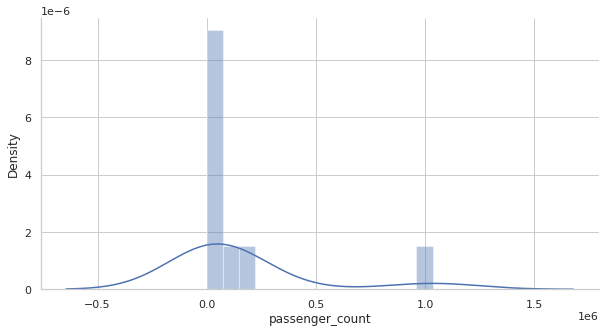

In [56]:
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.distplot(
    taxi_data['passenger_count'].value_counts()
    )


In [20]:
taxi_data['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [23]:
import datetime
taxi_data['pickup_year'] = taxi_data['pickup_datetime'].dt.year
taxi_data['pickup_month'] = taxi_data['pickup_datetime'].dt.month
taxi_data['pickup_day'] = taxi_data['pickup_datetime'].dt.day
taxi_data['pickup_hour'] = taxi_data['pickup_datetime'].dt.hour
taxi_data['pickup_minute'] = taxi_data['pickup_datetime'].dt.minute
taxi_data['pickup_second'] = taxi_data['pickup_datetime'].dt.second
taxi_data['pickup_day_name'] = taxi_data['pickup_datetime'].dt.day_name()

In [24]:
taxi_data['dropoff_year'] = taxi_data['dropoff_datetime'].dt.year
taxi_data['dropoff_month'] = taxi_data['dropoff_datetime'].dt.month
taxi_data['dropoff_day'] = taxi_data['dropoff_datetime'].dt.day
taxi_data['dropoff_hour'] = taxi_data['dropoff_datetime'].dt.hour
taxi_data['dropoff_minute'] = taxi_data['dropoff_datetime'].dt.minute
taxi_data['dropoff_second'] = taxi_data['dropoff_datetime'].dt.second
taxi_data['dropoff_day_name'] = taxi_data['dropoff_datetime'].dt.day_name()

Number of Trips count by week days

Text(0.5, 1.0, 'Number of trips in week days')

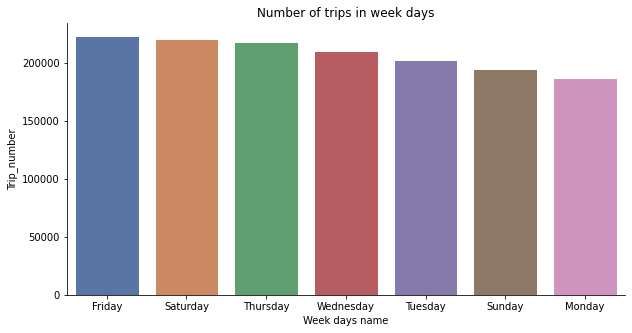

In [25]:
weekdays_number= taxi_data.pickup_day_name.value_counts().reset_index()
# Plotting graph
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.set_theme(style="whitegrid")
ax= sns.barplot(x='index',y='pickup_day_name',data=weekdays_number )
ax.set_ylabel("Trip_number")
ax.set_xlabel("Week days name")
plt.title("Number of trips in week days")

Avg duration of trips by week days

In [26]:
avg_duration_day= taxi_data.groupby(['pickup_day_name'])['trip_duration'].mean().reset_index().rename(columns={'trip_duration':'avg_trip_duration'}).sort_values(by = "avg_trip_duration" , ascending=False ,ignore_index=True)


In [27]:
avg_duration_day

,pickup_day_name,avg_trip_duration
0,Thursday,1006.528654
1,Friday,990.224200
2,Tuesday,983.463124
3,Wednesday,975.450494
4,Saturday,948.051175
5,Sunday,901.639395
6,Monday,897.947839


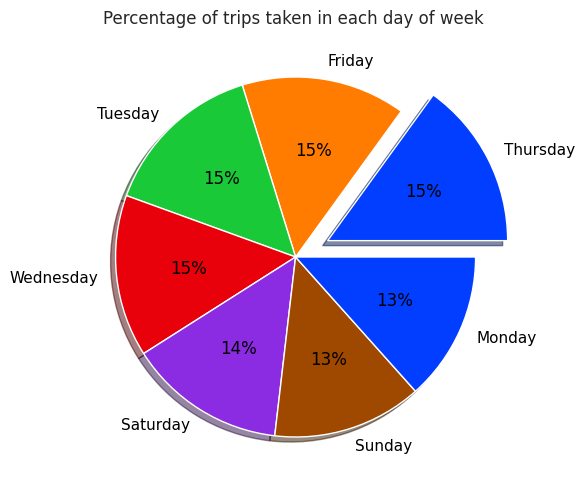

In [28]:
fig_1 = plt.figure(figsize=(8,5),dpi=100)
axes_1 = fig_1.add_axes([0.1,0.1,0.9,0.9])

explode = [0]*7
explode[0] = 0.2
colors = sns.color_palette('bright')[0:6]
z= avg_duration_day['pickup_day_name'].to_list()
plt.rcParams['text.color'] = 'black'
plt.pie(x=avg_duration_day['avg_trip_duration'],explode=explode,labels=z,labeldistance=1.1,colors=colors,shadow=True,textprops=dict(color="black"),autopct='%1.0f%%')
plt.title("Percentage of trips taken in each day of week ")
plt.show()

we will use number of to replace these days.

In [29]:
# one Hot encoding
encode_day= {'pickup_day_name':{'Monday':1,'Tuesday':2,'Wednesday':3,'Tuesday':4,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7},}
# replacing the date name with number
taxi_data=taxi_data.replace(encode_day)

Text(0.5, 1.0, 'Pickup Hours Distribution')

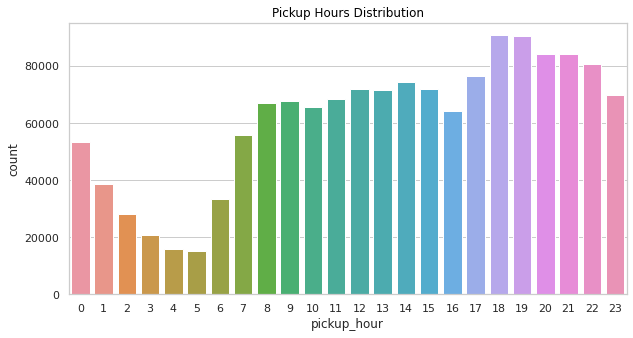

In [30]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x=taxi_data['pickup_hour'])
ax.set_title("Pickup Hours Distribution")

In [31]:
taxi_data['avg_speed(km/hr)']= round((((taxi_data['distance']*1000)/taxi_data['trip_duration'])*3600)/1000,2)

In [32]:
taxi_data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'pickup_year', 'pickup_month',
       'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_second',
       'pickup_day_name', 'dropoff_year', 'dropoff_month', 'dropoff_day',
       'dropoff_hour', 'dropoff_minute', 'dropoff_second', 'dropoff_day_name',
       'avg_speed(km/hr)'],
      dtype='object')

In [33]:
taxi_data[taxi_data['avg_speed(km/hr)']>180] 

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_name,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,dropoff_second,dropoff_day_name,avg_speed(km/hr)
1107,id0729156,2,2016-06-23 13:36:48,2016-06-23 13:36:50,3,-73.827660,40.716175,-73.822113,40.711452,0,2,0.703342,2016,6,23,13,36,48,4,2016,6,23,13,36,50,Thursday,1266.01
107171,id1656254,2,2016-01-18 00:35:38,2016-01-18 00:35:54,1,-73.805527,40.651360,-73.804230,40.661629,0,16,1.145626,2016,1,18,0,35,38,1,2016,1,18,0,35,54,Monday,257.77
133641,id2362780,2,2016-06-30 05:01:03,2016-06-30 05:01:11,1,-74.164268,40.711639,-74.179352,40.711342,0,8,1.274983,2016,6,30,5,1,3,4,2016,6,30,5,1,11,Thursday,573.74
171801,id1733307,2,2016-06-26 18:02:38,2016-06-26 18:02:50,1,-73.792725,40.656902,-73.788948,40.647270,0,12,1.116290,2016,6,26,18,2,38,7,2016,6,26,18,2,50,Sunday,334.89
176589,id1724402,1,2016-05-17 06:34:59,2016-05-17 06:36:27,1,-73.969231,40.798122,-73.999260,40.753773,0,88,5.539157,2016,5,17,6,34,59,4,2016,5,17,6,36,27,Tuesday,226.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328401,id1644758,2,2016-01-03 14:41:12,2016-01-03 14:44:19,1,-73.999992,40.689610,-73.965492,40.806030,0,187,13.252680,2016,1,3,14,41,12,7,2016,1,3,14,44,19,Sunday,255.13
1359910,id3628988,1,2016-05-05 18:21:37,2016-05-05 18:30:45,1,-79.569733,41.586273,-80.355431,42.090183,0,548,85.972969,2016,5,5,18,21,37,4,2016,5,5,18,30,45,Thursday,564.79
1390507,id3141426,2,2016-05-06 18:29:00,2016-05-06 18:29:05,1,-73.874718,40.730610,-73.867432,40.732868,0,5,0.664623,2016,5,6,18,29,0,5,2016,5,6,18,29,5,Friday,478.53
1398157,id2905190,2,2016-03-05 00:17:29,2016-03-05 00:17:32,1,-74.003487,40.732609,-74.004189,40.731274,0,3,0.159683,2016,3,5,0,17,29,6,2016,3,5,0,17,32,Saturday,191.62


some average speed was too much , like 250 km/hour, which was practically impossible , we will analyse the trip duration. 

we can see here that trip duration was so small , which was practically impossible, so we exclude rows of those, whose trip duration which was less than 30 seconds and which average speed was more than 180 km

In [57]:
taxi_data= taxi_data[taxi_data['avg_speed(km/hr)']<180]

In [58]:
taxi_data=taxi_data[taxi_data['trip_duration']<30]

In [37]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_name,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,dropoff_second,dropoff_day_name,avg_speed(km/hr)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,1.502172,2016,3,14,17,24,55,1,2016,3,14,17,32,30,Monday,11.89
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,1.808660,2016,6,12,0,43,35,7,2016,6,12,0,54,38,Sunday,9.82
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,6.379687,2016,1,19,11,35,24,4,2016,1,19,12,10,48,Tuesday,10.81
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1.483632,2016,4,6,19,32,31,3,2016,4,6,19,39,40,Wednesday,12.45
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1.187038,2016,3,26,13,30,55,6,2016,3,26,13,38,10,Saturday,9.82


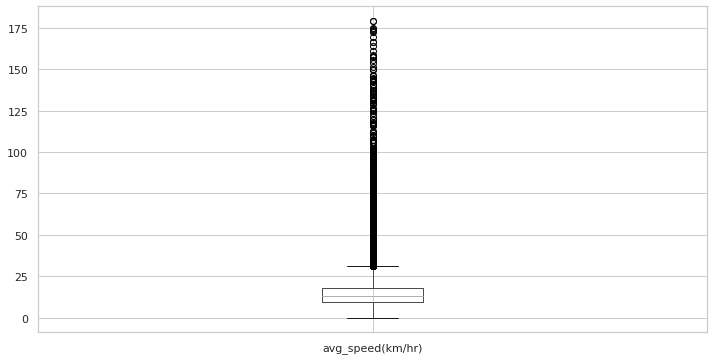

In [38]:
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='avg_speed(km/hr)')

outlier detection, 

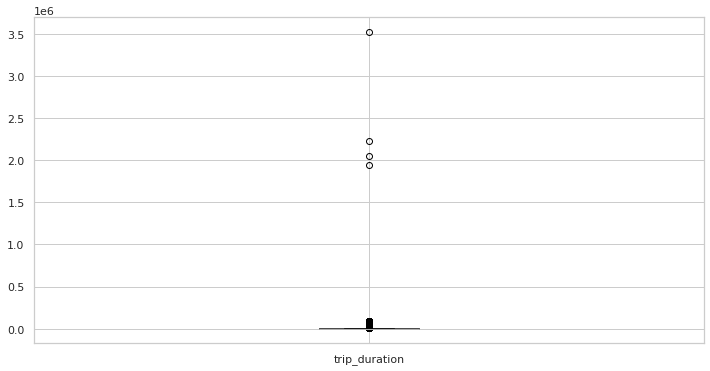

In [39]:
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='trip_duration')

In trip duration, there are some of the outliers. so we will see which of duration is more than one day. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


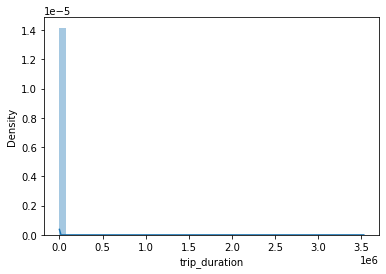

In [21]:
sns.distplot(
    taxi_data['trip_duration']
    )

In [40]:
# Outliers detection 
taxi_data[taxi_data.trip_duration>86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_name,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,dropoff_second,dropoff_day_name,avg_speed(km/hr)
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,0,1939736,20.160235,2016,1,5,0,19,42,4,2016,1,27,11,8,38,Wednesday,0.04
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,0,2049578,5.992874,2016,2,13,22,38,0,6,2016,3,8,15,57,38,Tuesday,0.01
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,0,2227612,1.633027,2016,1,5,6,14,15,4,2016,1,31,1,1,7,Sunday,0.00
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,0,3526282,19.926608,2016,2,13,22,46,52,6,2016,3,25,18,18,14,Friday,0.02


we can see some of these duratin are several days , so we use Log transformation of the trip duration results in a normal distribution.

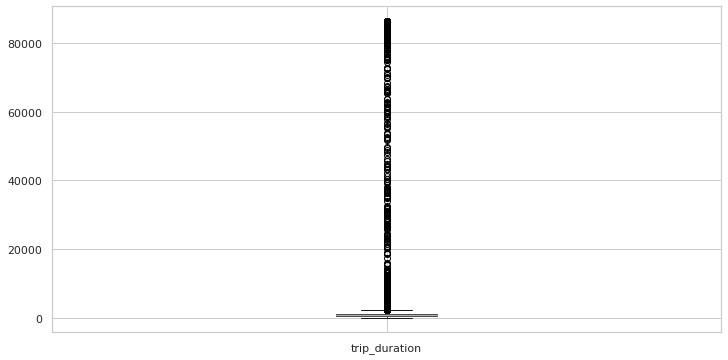

In [43]:
plt.figure(figsize=(12, 6))
taxi_data.boxplot(column='trip_duration')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

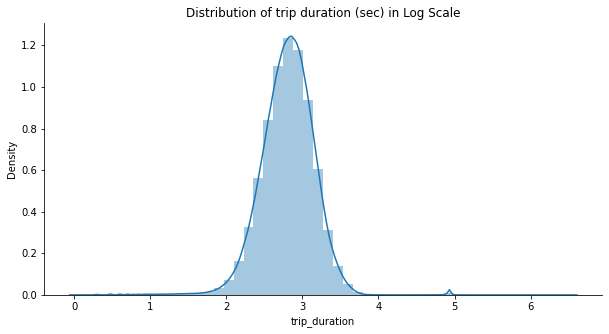

In [22]:
#log transformation
f, ax = plt.subplots(figsize=(10, 5))
sns.despine(f)
sns.distplot(
    np.log10(taxi_data['trip_duration']))
plt.title("Distribution of trip duration (sec) in Log Scale")

In [44]:
taxi_data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_second,pickup_day_name,dropoff_year,dropoff_month,dropoff_day,dropoff_hour,dropoff_minute,dropoff_second,avg_speed(km/hr)
count,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1458562.0,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1458562.0,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06,1.458562e+06
mean,1.534938e+00,1.664523e+00,-7.397349e+01,4.075092e+01,-7.397340e+01,4.075181e+01,5.515021e-03,9.528539e+02,3.437826e+00,2016.0,3.516819e+00,1.550404e+01,1.360647e+01,2.959022e+01,2.947354e+01,4.328356e+00,2016.0,3.517178e+00,1.550447e+01,1.359890e+01,2.962860e+01,2.950985e+01,1.437998e+01
std,4.987780e-01,1.314227e+00,7.034345e-02,3.031155e-02,6.925548e-02,3.430603e-02,7.405815e-02,3.171400e+03,3.957211e+00,0.0,1.681027e+00,8.703160e+00,6.399666e+00,1.732475e+01,1.731990e+01,1.776782e+00,0.0,1.681207e+00,8.703138e+00,6.483663e+00,1.742026e+01,1.731978e+01,7.828642e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.435970e+01,0.000000e+00,1.000000e+00,0.000000e+00,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2016.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073589e+01,0.000000e+00,3.970000e+02,1.232288e+00,2016.0,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,1.400000e+01,3.000000e+00,2016.0,2.000000e+00,8.000000e+00,9.000000e+00,1.500000e+01,1.500000e+01,9.120000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,0.000000e+00,6.620000e+02,2.094050e+00,2016.0,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,2.900000e+01,4.000000e+00,2016.0,4.000000e+00,1.500000e+01,1.400000e+01,3.000000e+01,2.900000e+01,1.279000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396302e+01,4.076981e+01,0.000000e+00,1.075000e+03,3.874611e+00,2016.0,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,4.400000e+01,6.000000e+00,2016.0,5.000000e+00,2.300000e+01,1.900000e+01,4.500000e+01,4.500000e+01,1.784000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.391176e+01,-6.133553e+01,4.391176e+01,1.000000e+00,8.639200e+04,1.918180e+02,2016.0,6.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01,7.000000e+00,2016.0,7.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,5.900000e+01,1.790900e+02


In [63]:
taxi_data['hour_spend']= taxi_data['dropoff_hour'] - taxi_data['pickup_hour']
taxi_data['min_spend']= taxi_data['dropoff_minute'] - taxi_data['pickup_minute']

In [64]:
col_to_drop= ['pickup_longitude', 'pickup_latitude','dropoff_longitude',
                         'dropoff_latitude','pickup_year','dropoff_year',
                         'dropoff_day_name','dropoff_month','dropoff_day','dropoff_hour','pickup_hour','pickup_minute','dropoff_minute']
taxi_df= taxi_data.drop(col_to_drop, axis=1)

In [65]:
taxi_df.corr()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance,pickup_month,pickup_day,pickup_second,pickup_day_name,dropoff_second,avg_speed(km/hr),hour_spend,min_spend
vendor_id,1.000000e+00,3.007872e-01,-1.071296e-01,5.499572e-02,1.390116e-16,-1.240206e-02,2.993250e-02,2.803384e-04,2.824697e-02,-1.916156e-02,2.371411e-01,5.200402e-03,-1.841062e-03
passenger_count,3.007872e-01,1.000000e+00,-2.784242e-02,8.983666e-02,5.210646e-16,1.838193e-02,1.734790e-02,-7.733756e-03,2.454722e-02,-1.637614e-02,7.013142e-02,9.323406e-04,2.877117e-03
store_and_fwd_flag,-1.071296e-01,-2.784242e-02,1.000000e+00,-1.999750e-02,8.683072e-16,9.992786e-03,-1.203415e-02,-1.801573e-02,-2.407846e-02,-4.581277e-04,-3.770087e-02,-9.270969e-03,7.321362e-03
trip_duration,5.499572e-02,8.983666e-02,-1.999750e-02,1.000000e+00,-1.292543e-15,6.299205e-04,-1.988553e-02,-3.160309e-02,3.784023e-03,-1.545107e-03,-4.139260e-02,3.464101e-02,-1.911936e-03
distance,1.390116e-16,5.210646e-16,8.683072e-16,-1.292543e-15,1.000000e+00,7.857106e-18,7.000614e-16,6.189500e-16,1.594088e-15,1.557688e-16,3.135559e-16,4.762813e-16,5.364236e-16
pickup_month,-1.240206e-02,1.838193e-02,9.992786e-03,6.299205e-04,7.857106e-18,1.000000e+00,-8.311325e-03,-2.990057e-02,8.247544e-03,2.266679e-02,-1.269387e-02,1.033096e-03,-4.956380e-03
pickup_day,2.993250e-02,1.734790e-02,-1.203415e-02,-1.988553e-02,7.000614e-16,-8.311325e-03,1.000000e+00,1.551376e-02,9.629350e-03,9.616940e-03,2.383382e-02,-2.004943e-02,1.993304e-02
pickup_second,2.803384e-04,-7.733756e-03,-1.801573e-02,-3.160309e-02,6.189500e-16,-2.990057e-02,1.551376e-02,1.000000e+00,-6.833640e-03,5.625640e-02,3.159614e-03,7.596530e-02,-7.080962e-03
pickup_day_name,2.824697e-02,2.454722e-02,-2.407846e-02,3.784023e-03,1.594088e-15,8.247544e-03,9.629350e-03,-6.833640e-03,1.000000e+00,-5.542306e-03,-2.105544e-03,-1.688524e-02,1.704691e-02
dropoff_second,-1.916156e-02,-1.637614e-02,-4.581277e-04,-1.545107e-03,1.557688e-16,2.266679e-02,9.616940e-03,5.625640e-02,-5.542306e-03,1.000000e+00,1.336279e-02,-8.211113e-02,1.177062e-02


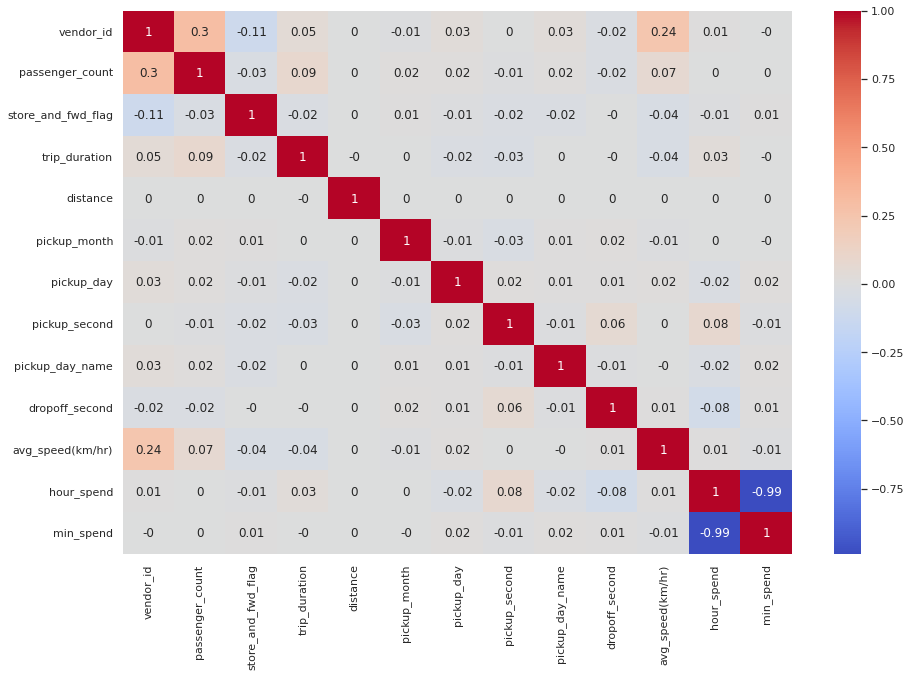

In [66]:
plt.figure(figsize=(15,10))
sns.heatmap(round(taxi_df.corr(),2),annot=True,cmap='coolwarm')

In [67]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [69]:
X= taxi_df.drop(['trip_duration'],axis=1)

In [70]:
y= np.log10(taxi_df['trip_duration'])

In [ ]:
scale = MinMaxScaler()
